In [15]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import netCDF4
import cmocean
import colorcet
import scipy.interpolate


import coastviewer.extra_cm
%matplotlib inline

In [16]:
DATASETS = {
    'transect': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/jarkus/profiles/transect.nc',  # nopep8
    'BKL_TKL_TND': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/BKL_TKL_TND.nc',  # nopep8
    'DF': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/DuneFoot/DF.nc',  # nopep8
    'mkl': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/MKL.nc',  # nopep8
    'strandbreedte': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/strandbreedte/strandbreedte.nc',  # nopep8
    'strandlijnen': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/MHW_MLW/MHW_MLW.nc',  # nopep8
    'suppleties': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/suppleties/suppleties.nc',  # nopep8
    'faalkans': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/faalkans_PC-Ring/faalkans.nc'  # nopep8
}
local = True
if local:
    DATASETS['transect'] = str(pathlib.Path('../data/transect.nc'))


In [24]:
# global variables
with netCDF4.Dataset(DATASETS['transect']) as ds:
    # keep these global, for faster indexing
    ids = ds.variables['id'][:]
    print(ds.variables['mean_high_water'])

<class 'netCDF4._netCDF4.Variable'>
float64 mean_high_water(alongshore)
    long_name: mean high water level
    units: m
    comment: mean high water level relative to nap
unlimited dimensions: 
current shape = (2268,)
filling off



In [ ]:
def fill(z):
    """fill z by space and then time"""
    def fill_space(z):
        """fill space"""
        x = np.arange(z.shape[0])
        F = scipy.interpolate.interp1d(x[~z.mask], z[~z.mask], bounds_error=False)
        z_interp = F(x)
        z_filled = np.ma.masked_invalid(z_interp)
        return z_filled
    def fill_time(z):
        """fill time"""
        z_filled = np.ma.masked_all_like(z)
        for i in range(z.shape[1]):
            arr = z[:, i]
            # if there's no data, continue
            if arr.mask.all():
                continue
            # interpolate in time
            xp = np.arange(len(arr))
            z_filled[:, i] = scipy.interp(xp, xp[~arr.mask], arr[~arr.mask])
        return z_filled

    filled_z = np.ma.apply_along_axis(fill_space, 1, data['z'])
    filled_z = fill_time(filled_z)
    return filled_z

    

In [49]:
def get_transect_data(id_=7003900):
    transect_idx = np.searchsorted(ids, id_)
    variables = {
        'lat': {"var": 'lat', "slice": np.s_[transect_idx, :]},
        'lon': {"var": 'lon', "slice": np.s_[transect_idx, :]},
        'z': {"var": 'altitude', "slice": np.s_[:, transect_idx, :]},
        "t": {"var": 'time', "slice": np.s_[:]},
        "cross_shore": {"var": "cross_shore", "slice": np.s_[:]},
        'mean_high_water': {"var": 'mean_high_water', "slice": np.s_[transect_idx]},
        'mean_low_water': {"var": 'mean_low_water', "slice": np.s_[transect_idx]},


    }
    data = {}
    with netCDF4.Dataset(DATASETS['transect']) as ds:
        for var, props in variables.items():
            data[var] = ds.variables[props['var']][props['slice']]
        time_units = ds.variables['time'].units
    data['time'] = netCDF4.num2date(data['t'], time_units)
    data['filled_z'] = fill(data['z'])
    data['time_num'] = matplotlib.dates.date2num(data['time'])
    return data


In [50]:
def time_map(data):
    fig, ax = plt.subplots(figsize=(8, 3))
    pc = ax.pcolorfast(data['cross_shore'], data['time_num'], data['filled_z'], vmin=-20, vmax=20, cmap=coastviewer.extra_cm.GMT_drywet_r)
    cont = ax.contour(
        data['cross_shore'], 
        data['time_num'], 
        data['z'],
        levels=[data['mean_low_water'], data['mean_high_water'], 3],
        cmap='PuBu'
    )
    # legend
    cb = plt.colorbar(pc, ax=ax)

    # labels
    cb.set_label('Height to NAP [m]')
    ax.set_xlabel('Cross shore distance [m]')
    ax.set_ylabel('Measurement time [y]')

    # date format
    date_locator = matplotlib.dates.AutoDateLocator()
    date_formatter = matplotlib.dates.AutoDateFormatter(date_locator)
    ax.yaxis.set_major_formatter(date_formatter)
    return fig, ax

(<matplotlib.figure.Figure at 0x112edc630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x113b0fb00>)

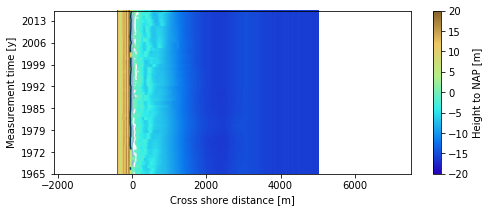

In [51]:
data = get_transect_data()
time_map(data)

